<a href="https://colab.research.google.com/github/TanZz9/LearnPyTorch/blob/main/4_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import PyTorch and setup device agnostic code

In [1]:
import torch
from torch import nn
from torchvision.transforms import v2
import tqdm
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Get Data

In [5]:
import requests
import zipfile
from pathlib import Path

# set up a path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists...")
else:
  print(f"{image_path} does not exits, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# print(data_path)
# Download the images
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

# Unzip the file
zipfile_path = data_path / "pizza_steak_sushi.zip"
with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
  print("Unzipping the zip file")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists...
Unzipping the zip file


# 2. Become one with the data

In [6]:
import os
def walk_through_dir(path):
  for dirpath, dirnames, filenames in os.walk(path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 files in data/pizza_steak_sushi
There are 3 directories and 0 files in data/pizza_steak_sushi/test
There are 0 directories and 19 files in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 files in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 files in data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 files in data/pizza_steak_sushi/train
There are 0 directories and 75 files in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 files in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 files in data/pizza_steak_sushi/train/sushi


In [8]:
train_path = image_path/ "train"
test_path = image_path / "test"
train_path, test_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Path: data/pizza_steak_sushi/train/pizza/702165.jpg
Image class: pizza


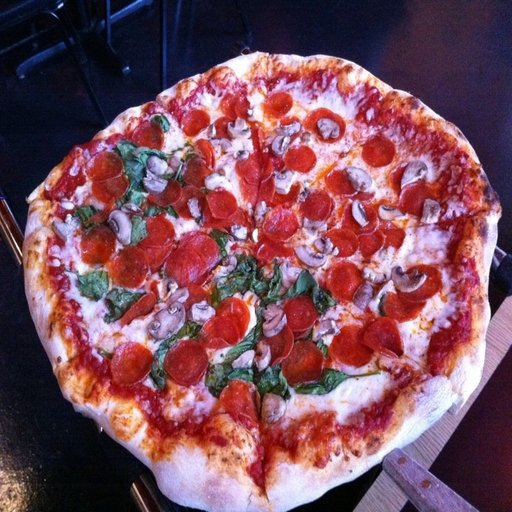

In [12]:
import random
from PIL import Image
image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Path: {random_image_path}\nImage class: {image_class}")
img


# 3. Transform data

<class 'PIL.Image.Image'>


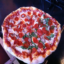

In [34]:
from torch.utils.data import DataLoader
from torchvision import datasets

data_transform_0 = v2.Compose([
    v2.Resize(size=(64, 64)), # Resize images to 64 * 64
    v2.RandomHorizontalFlip(p=0.5), # Flip the images randomly on the horizontal
    v2.ToDtype(torch.float32, scale=True),
    # v2.PILToTensor()
])

print(type(data_transform_0(img)))
data_transform_0(img)

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


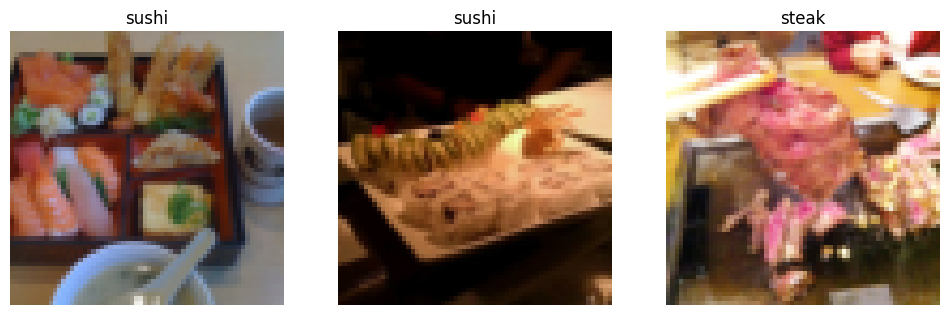

In [37]:
import numpy as np
def plot_transformed_images_0(image_path_list, transform, n=3):
  random_image_samples = random.sample(image_path_list, k=n)
  plt.figure(figsize=(12, 12))
  i = 1
  for x in random_image_samples:
    class_name = x.parent.stem
    img = np.asarray(transform(Image.open(x)))
    print(img.shape)
    plt.subplot(1, n, i)
    i += 1
    plt.imshow(img)
    plt.title(class_name)
    plt.axis(False)
plot_transformed_images_0(image_path_list, data_transform_0, 3)


In [36]:
data_transform = v2.Compose([
    v2.Resize(size=(64, 64)), # Resize images to 64 * 64
    v2.RandomHorizontalFlip(p=0.5), # Flip the images randomly on the horizontal
    v2.ToDtype(torch.float32, scale=True),
    v2.PILToTensor()
])

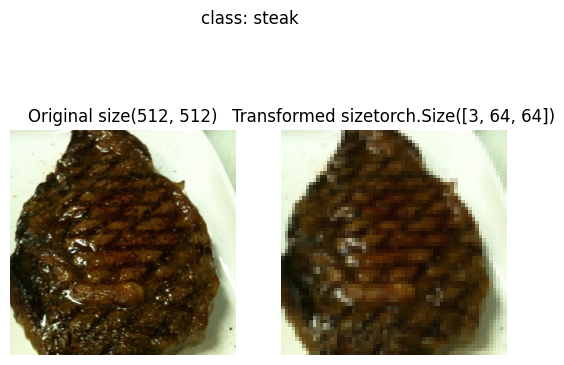

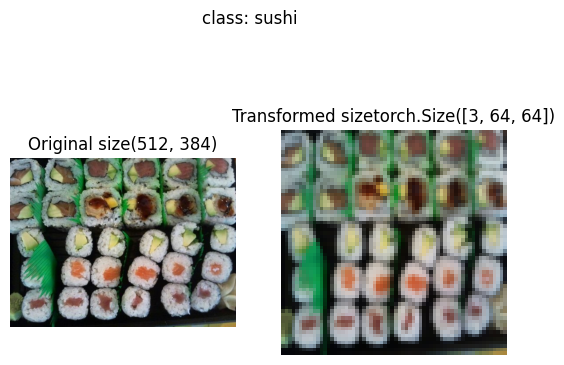

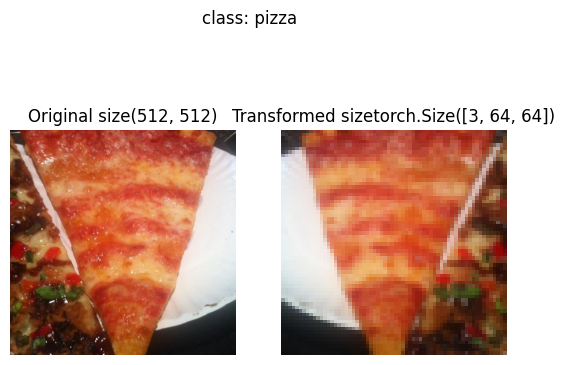

In [44]:
def plot_transformed_images(image_path_list, transform, n):
  random_image_path = random.sample(image_path_list, k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
      ax1.imshow(f)
      ax1.set_title(f"Original size{f.size}")
      ax1.axis(False)

      # Transformed image
      transformed_image = transform(f)
      ax2.imshow(transformed_image.permute((1, 2, 0)))
      ax2.set_title(f"Transformed size{transformed_image.shape}")
      ax2.axis(False)

      fig.suptitle(f"class: {image_path.parent.stem}")
plot_transformed_images(image_path_list, data_transform, 3)

# 4. Loading image data using ImageFolder

In [45]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                  RandomHorizontalFlip(p=0.5)
                  ToDtype(scale=True)
                  PILToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                  RandomHorizontalFlip(p=0.5)
                  ToDtype(scale=True)
                  PILToTensor()
            ))

In [47]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

pizza


(-0.5, 63.5, 63.5, -0.5)

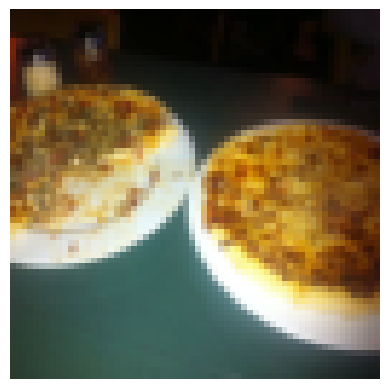

In [53]:
img, label = train_data[0]
print(class_names[label])
plt.imshow(img.permute((1, 2, 0)))
plt.axis(False)

In [57]:
import os
os.cpu_count()

2

In [58]:
Batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=Batch_size,
    shuffle=True,
    num_workers=os.cpu_count()
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=Batch_size,
    shuffle=False,
    num_workers=os.cpu_count()
)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d2fac94e050>,
 <torch.utils.data.dataloader.DataLoader at 0x7d2fac94fbb0>)

In [59]:
img, label = next(iter(train_dataloader))
img.shape, label

(torch.Size([32, 3, 64, 64]),
 tensor([0, 1, 0, 2, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 2, 0, 1, 2, 2,
         2, 0, 2, 1, 1, 1, 1, 1]))

# 5. Load a Image data with a Custom `Dataset`

In [ ]:
import os
import pathlib
import torch

from PIL import Image


# 6. Data augmentation

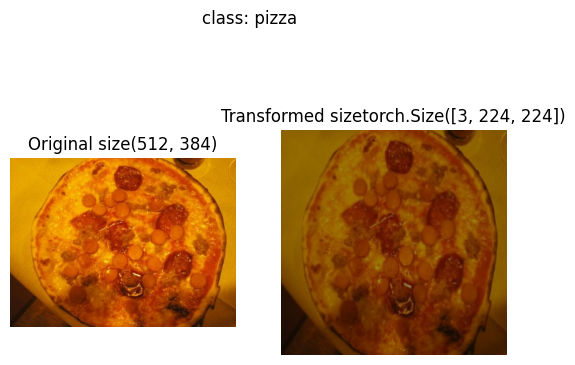

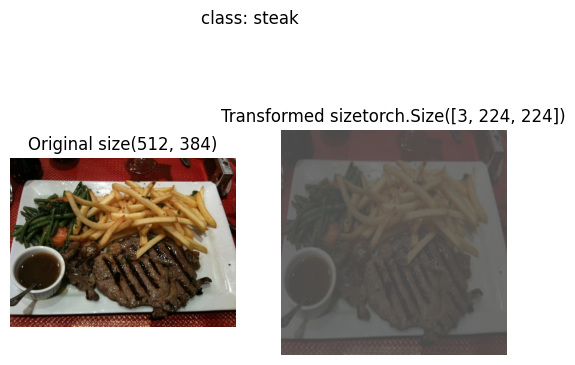

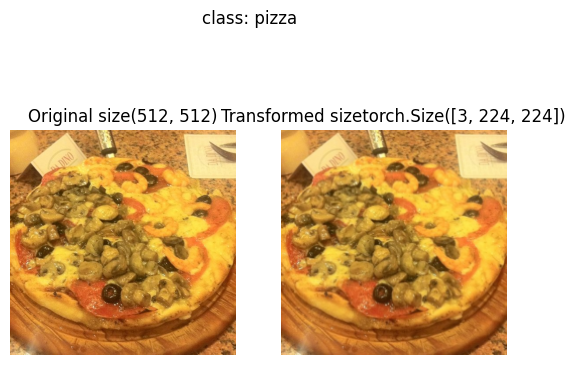

In [64]:
train_transform = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.TrivialAugmentWide(num_magnitude_bins=31),
    v2.ToDtype(torch.float, scale=True),
    v2.PILToTensor()
])

test_transform = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToDtype(torch.float, scale=True),
    v2.PILToTensor()
])

plot_transformed_images(image_path_list,
                        train_transform,
                        n=3)

# 7. Model 0: TinyVgg without data augmentation

In [89]:
# transform and dataloader
simple_transform = v2.Compose([
    v2.Resize(size=(64, 64)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float, True),
])

In [90]:
simple_train_data = datasets.ImageFolder(root=train_path, transform=simple_transform, target_transform=None)
simple_test_data = datasets.ImageFolder(root=test_path, transform=simple_transform, target_transform=None)

BATCH_SIZE = 32
NUM_WORKERS =  os.cpu_count()

simple_train_dataloader = DataLoader(dataset=simple_train_data,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS
                                     )
simple_test_dataloader = DataLoader(dataset=simple_test_data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS
                                    )
simple_train_dataloader, simple_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d2facfae2f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d2facfac9a0>)

In [96]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value equals to kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16, out_features=3),
    )

  def forward(self, x):
    # x = self.conv_block_1(x)
    # print(x.shape)
    # x = self.conv_block_2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # print(x.shape)
    # return x
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [122]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_0 = TinyVGG(3, 10, 3).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [123]:
# Get a single image batch
image_batch, label_batch = next(iter(simple_train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [124]:
image_batch[0].dtype

torch.float32

In [125]:
image_batch = image_batch.to(device)
model0_output_batch = model_0(image_batch).cpu()
model0_output_batch[0]

tensor([0.0578, 0.0634, 0.0351], grad_fn=<SelectBackward0>)

In [126]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [127]:
from tqdm.auto import tqdm
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  model.to(device)
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in tqdm(enumerate(dataloader)):
    X, y = X.to(device), y.to(device)

    y_logits = model(X)

    loss = loss_fn(y_logits, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_preds = torch.argmax(torch.sigmoid(y_logits), dim=1)
    train_acc += (y_preds == y).sum().item() / len(y)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device):
  model.to(device)
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in tqdm(enumerate(dataloader)):
      X, y = X.to(device), y.to(device)

      y_logits = model(X)

      loss = loss_fn(y_logits, y)
      test_loss += loss.item()

      y_preds = torch.argmax(torch.sigmoid(y_logits), dim=1)
      test_acc += (y_preds == y).sum().item() / len(y_preds)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

In [128]:
def train(model: nn.Module,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          epochs: int=5,
          device: torch.device = device):
    results = {"train_loss":[],
               "train_acc":[],
               "test_loss":[],
               "test_acc":[]}
    for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
      test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

    return results


In [129]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.1)

from timeit import default_timer as timer

start_time = timer()

model0_results = train(model_0, loss_fn, optimizer, simple_test_dataloader, simple_test_dataloader, NUM_EPOCHS)

end_time = timer()

print(f"Total Training Time: {end_time - start_time} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1160.0966 | train_acc: 0.1979 | test_loss: 34.4505 | test_acc: 0.5417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 28.5965 | train_acc: 0.2083 | test_loss: 1.1086 | test_acc: 0.2604


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 1.1123 | train_acc: 0.2604 | test_loss: 1.1013 | test_acc: 0.2604


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4 | train_loss: 1.0900 | train_acc: 0.2604 | test_loss: 1.0794 | test_acc: 0.5417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5 | train_loss: 1.0618 | train_acc: 0.5417 | test_loss: 1.0545 | test_acc: 0.5417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 6 | train_loss: 1.0357 | train_acc: 0.5417 | test_loss: 1.0331 | test_acc: 0.5417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 7 | train_loss: 1.0159 | train_acc: 0.5417 | test_loss: 1.0179 | test_acc: 0.5417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 8 | train_loss: 1.0037 | train_acc: 0.5417 | test_loss: 1.0088 | test_acc: 0.5417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 9 | train_loss: 0.9980 | train_acc: 0.5417 | test_loss: 1.0047 | test_acc: 0.5417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 10 | train_loss: 0.9972 | train_acc: 0.5417 | test_loss: 1.0037 | test_acc: 0.5417
Total Training Time: 14.365780165997421 seconds


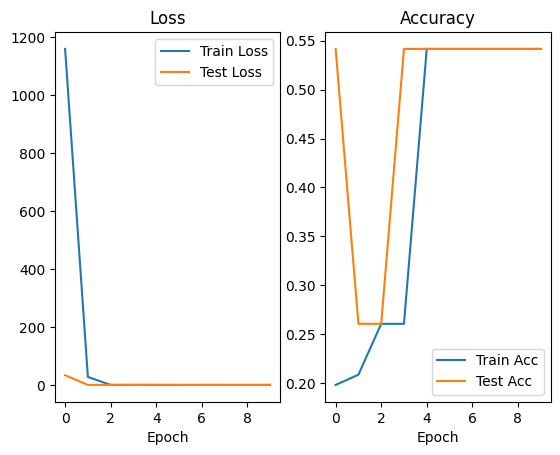

In [132]:
from typing import Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
  epochs = range(len(results["train_loss"]))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, results["train_loss"], label="Train Loss")
  plt.plot(epochs, results["test_loss"], label="Test Loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, results["train_acc"], label="Train Acc")
  plt.plot(epochs, results["test_acc"], label="Test Acc")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.legend()

plot_loss_curves(model0_results)

# Data Augmentation

In [134]:
train_transform_augmented = v2.Compose([
    v2.Resize(size=(64, 64)),
    v2.TrivialAugmentWide(num_magnitude_bins=31),
    v2.PILToTensor(),
    v2.ToDtype(torch.float)
])

augmented_train_data = datasets.ImageFolder(train_path, train_transform_augmented)
augmented_train_dataloader = DataLoader(dataset=augmented_train_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

augmented_train_dataloader

In [135]:
model_1 = TinyVGG(
    3,
    10,
    3,
).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [137]:
torch.manual_seed(42)

optimizer_1 = torch.optim.Adam(params=model_1.parameters(), lr=0.1)

train_start_time = timer()

model1_results = train(model_1,
                       loss_fn,
                       optimizer_1,
                       augmented_train_dataloader,
                       simple_test_dataloader,
                       NUM_EPOCHS
                       )

train_end_time = timer()

print(f"Total Training Time: {train_end_time - train_start_time} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.1184 | train_acc: 0.2617 | test_loss: 1.1194 | test_acc: 0.1979


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 1.0755 | train_acc: 0.3984 | test_loss: 1.1626 | test_acc: 0.2604


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 1.0850 | train_acc: 0.4258 | test_loss: 1.1928 | test_acc: 0.2604


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4 | train_loss: 1.1395 | train_acc: 0.3047 | test_loss: 1.1638 | test_acc: 0.2604


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5 | train_loss: 1.1031 | train_acc: 0.2969 | test_loss: 1.1594 | test_acc: 0.1979


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 6 | train_loss: 1.0958 | train_acc: 0.4141 | test_loss: 1.1438 | test_acc: 0.1979


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 7 | train_loss: 1.0878 | train_acc: 0.4141 | test_loss: 1.1515 | test_acc: 0.1979


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 8 | train_loss: 1.1237 | train_acc: 0.2930 | test_loss: 1.1659 | test_acc: 0.1979


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 9 | train_loss: 1.1289 | train_acc: 0.2930 | test_loss: 1.1438 | test_acc: 0.2604


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 10 | train_loss: 1.0953 | train_acc: 0.2969 | test_loss: 1.0652 | test_acc: 0.5417
Total Training Time: 25.936869340999692 seconds


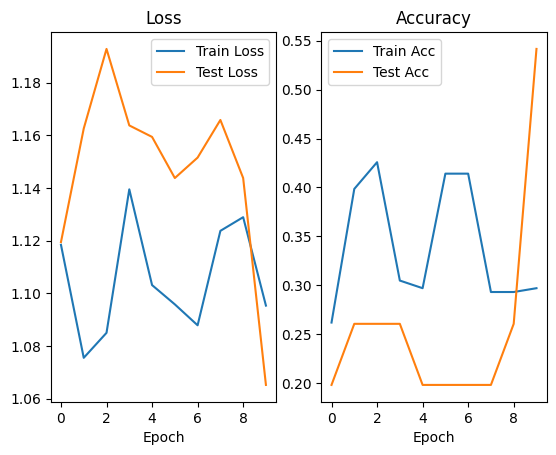

In [138]:
plot_loss_curves(model1_results)

In [140]:
model1_results_1 = train(model_1,
                       loss_fn,
                       optimizer_1,
                       augmented_train_dataloader,
                       simple_test_dataloader,
                       NUM_EPOCHS
                       )

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.1155 | train_acc: 0.2539 | test_loss: 1.0626 | test_acc: 0.5417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 1.1088 | train_acc: 0.2461 | test_loss: 1.0880 | test_acc: 0.2604


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 1.1207 | train_acc: 0.2812 | test_loss: 1.0711 | test_acc: 0.5417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4 | train_loss: 1.1093 | train_acc: 0.3008 | test_loss: 1.1245 | test_acc: 0.1979


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5 | train_loss: 1.1245 | train_acc: 0.2422 | test_loss: 1.0816 | test_acc: 0.5417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 6 | train_loss: 1.1162 | train_acc: 0.2695 | test_loss: 1.1238 | test_acc: 0.2604


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 7 | train_loss: 1.1306 | train_acc: 0.2656 | test_loss: 1.1539 | test_acc: 0.1979


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 8 | train_loss: 1.0944 | train_acc: 0.4180 | test_loss: 1.0755 | test_acc: 0.5417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 9 | train_loss: 1.0850 | train_acc: 0.4023 | test_loss: 1.0283 | test_acc: 0.5417


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 10 | train_loss: 1.0987 | train_acc: 0.4023 | test_loss: 1.0263 | test_acc: 0.5417


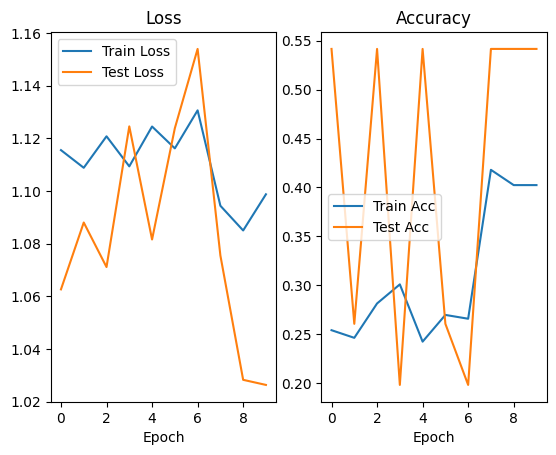

In [141]:
plot_loss_curves(model1_results_1)
